In [288]:
# 训练2天，48小时，画如下几个图：
# 1. loss图2张，每张包含Landlord，LandlordDown，LandlordUP
# 2. ADP和WP图，4张图，每张图是Landlord和Peasants
# 3. Accuracy图，3张，Landlord，LandlordDown，LandlordUP
# 4. WP 对抗SL智能体，ADP对抗SL智能体
# 5. WP对抗DeltaDou智能体，ADP对抗DeltaDou智能体

In [289]:
# 复制数据：
# 将douzero_checkpoints\douzero\logs.csv复制到image\ADP_WP\logs_adp.csv
# 将douzero_checkpoints\douzero\logs.csv复制到image\loss\logs_adp.csv
# 将douzero_checkpoints_wp\douzero\logs.csv复制到image\ADP_WP\logs_adp.csv
# 将douzero_checkpoints_wp\douzero\logs.csv复制到image\loss\logs_wp.csv

import shutil
import os

if not os.path.exists('./log_for_image/ADP_WP/'):
    os.makedirs('./log_for_image/ADP_WP/')
if not os.path.exists('./log_for_image/loss/'):
    os.makedirs('./log_for_image/loss/')
# 复制logs.csv到image\ADP_WP\logs_adp.csv
shutil.copy('.\douzero_checkpoints\douzero\logs.csv', '.\log_for_image\ADP_WP\logs_adp.csv')

# 复制logs.csv到image\loss\logs_adp.csv
shutil.copy('.\douzero_checkpoints\douzero\logs.csv', '.\log_for_image\loss\logs_adp.csv')

# 复制logs.csv到image\ADP_WP\logs_wp.csv
shutil.copy('.\douzero_checkpoints_wp\douzero\logs.csv', '.\log_for_image\ADP_WP\logs_wp.csv')

# 复制logs.csv到image\loss\logs_wp.csv
shutil.copy('.\douzero_checkpoints_wp\douzero\logs.csv', '.\log_for_image\loss\logs_wp.csv')

'.\\log_for_image\\loss\\logs_wp.csv'

In [290]:
# 函数定义，删除除第一行外的所有header行
def remove_extra_headers(file_path, output_file_path):
    with open(file_path, 'r') as infile, open(output_file_path, 'w') as outfile:
        header_line = next(infile)
        outfile.write(header_line)
        for line in infile:
            if not line.startswith("# _tick"):
                outfile.write(line)

# 处理文件
remove_extra_headers('.\log_for_image\ADP_WP\logs_adp.csv', '.\log_for_image\ADP_WP\logs_adp_processed.csv')
remove_extra_headers('.\log_for_image\loss\logs_adp.csv', '.\log_for_image\loss\logs_adp_processed.csv')
remove_extra_headers('.\log_for_image\ADP_WP\logs_wp.csv', '.\log_for_image\ADP_WP\logs_wp_processed.csv')
remove_extra_headers('.\log_for_image\loss\logs_wp.csv', '.\log_for_image\loss\logs_wp_processed.csv')


In [291]:
import pandas as pd

def shift_time_column(file_path):
    # 读取CSV文件
    df = pd.read_csv(file_path)

    # 将_time列转换为日期时间类型
    df['_time'] = pd.to_datetime(df['_time'], unit='s')

    # 计算时间间隔
    df['time_diff'] = df['_time'].diff()

    # 设置间隔阈值为10分钟
    threshold = pd.Timedelta(minutes=10)

    # 检测大于阈值的时间间隔
    mask = df['time_diff'] > threshold

    # 获取大于阈值的时间间隔的索引
    indices = mask[mask].index

    # 前一大间隔时间的结束
    prev_end_time = df['_time'].iloc[0]

    # 循环处理每个大间隔
    for i in range(len(indices)):
        start_index = indices[i] if i == 0 else indices[i-1] + 1
        end_index = indices[i]

        # 重新设置间隔内的时间
        df.loc[start_index:end_index, '_time'] = prev_end_time + pd.to_timedelta(range(1, end_index-start_index+2), unit='s')

        # 更新前一大间隔时间的结束
        prev_end_time = df['_time'].iloc[end_index]

    # 如果最后一个大间隔后还有数据，还需要处理
    if len(indices) > 0 and indices[-1] < len(df) - 1:
        start_index = indices[-1] + 1
        end_index = len(df) - 1
        df.loc[start_index:end_index+1, '_time'] = prev_end_time + pd.to_timedelta(range(1, end_index-start_index+2), unit='s')

    # 删除中间计算列
    df = df.drop('time_diff', axis=1)

    # 将时间戳转换为整数形式（UNIX时间戳）
    df['_time'] = (df['_time'] - pd.Timestamp("1970-01-01")) // pd.Timedelta(seconds=1)

    # 保存修改后的数据
    df.to_csv(file_path, index=False)

shift_time_column('.\log_for_image\loss\logs_wp_processed.csv')
shift_time_column('.\log_for_image\loss\logs_adp_processed.csv')
shift_time_column('.\log_for_image\ADP_WP\logs_adp_processed.csv')
shift_time_column('.\log_for_image\ADP_WP\logs_wp_processed.csv')


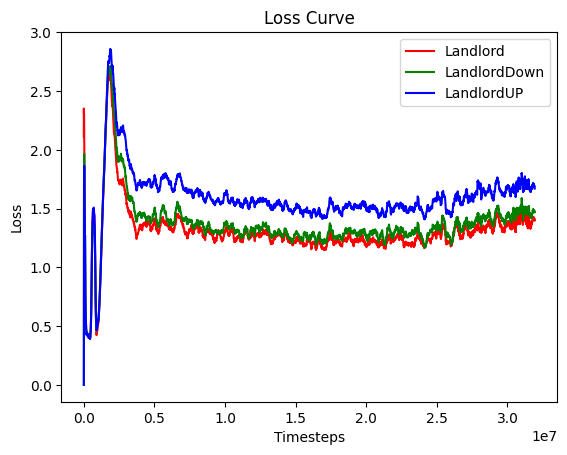

In [292]:
# 绘制的ADP的loss图

# 1. loss图2张，每张包含Landlord，LandlordDown，LandlordUP
# x轴Timesteps, y轴Loss
# Landlord 红色
# LandlordDown 绿色
# LandlordUP 蓝色

# 从./douzero_checkpoints/douzero/logs.csv读取数据
# logs.csv中的数据有多列，其中frames代表timesteps, loss_landlord, loss_landlord_up, loss_landlord_down为对应的损失
# 将图片按照如下格式保存./image/loss/loss_{frames}_landlord_down_up.png
import pandas as pd
import matplotlib.pyplot as plt
import os

# 读取CSV文件中的数据
logs = pd.read_csv(f'.\log_for_image\loss\logs_adp_processed.csv')

# 按照timesteps（frames）排序
logs = logs.sort_values(by=['frames'])

# 对每个损失值应用滑动窗口平均函数，使其平滑处理
window_size = 80
logs['smooth_loss_landlord'] = logs['loss_landlord'].rolling(window=window_size, min_periods=1).mean()
logs['smooth_loss_landlord_down'] = logs['loss_landlord_down'].rolling(window=window_size, min_periods=1).mean()
logs['smooth_loss_landlord_up'] = logs['loss_landlord_up'].rolling(window=window_size, min_periods=1).mean()

# 绘制Landlord、LandlordDown和LandlordUP的损失曲线
plt.plot(logs['frames'], logs['smooth_loss_landlord'], color='red', label='Landlord')
plt.plot(logs['frames'], logs['smooth_loss_landlord_down'], color='green', label='LandlordDown')
plt.plot(logs['frames'], logs['smooth_loss_landlord_up'], color='blue', label='LandlordUP')

# 设置标题和轴标签
plt.title('Loss Curve')
plt.xlabel('Timesteps')
plt.ylabel('Loss')

# 显示图例
plt.legend()

# 保存图片到本地路径./image/loss/
# 检查文件夹是否存在，不存在则创建
if not os.path.exists('./image/loss/'):
    os.makedirs('./image/loss/')
filename = './image/loss/adp_loss_{}_landlord_down_up.png'.format(int(logs['frames'].max()))
plt.savefig(filename)

# 显示图表
plt.show()

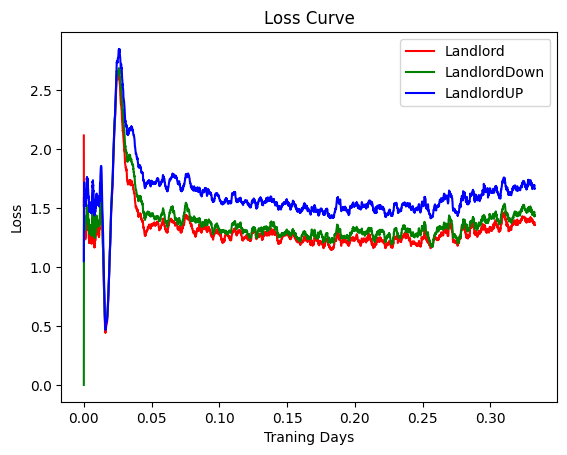

In [293]:
# ADP的loss图
import pandas as pd
import matplotlib.pyplot as plt
import os

# 读取CSV文件中的数据
logs = pd.read_csv(f'.\log_for_image\loss\logs_adp_processed.csv')

# 将时间戳转换为datetime格式并按照日期排序
logs['_time'] = pd.to_datetime(logs['_time'], unit='s')

# 计算每个时间点距离最早时间点的天数，并创建一个新列
earliest_time = logs['_time'].min()
logs['days_since_earliest'] = (logs['_time'] - earliest_time).dt.total_seconds() / 86400.

# 按天聚合数据并计算每个组的平均损失值
logs_daily = logs.groupby('days_since_earliest').mean()

# 对每个损失应用滑动窗口平均函数，以平滑处理
window_size = 80
logs_daily['smooth_loss_landlord'] = logs_daily['loss_landlord'].rolling(window=window_size, min_periods=1).mean()
logs_daily['smooth_loss_landlord_down'] = logs_daily['loss_landlord_down'].rolling(window=window_size, min_periods=1).mean()
logs_daily['smooth_loss_landlord_up'] = logs_daily['loss_landlord_up'].rolling(window=window_size, min_periods=1).mean()

# 绘制Landlord、LandlordDown和LandlordUP的损失曲线
plt.plot(logs_daily.index, logs_daily['smooth_loss_landlord'], color='red', label='Landlord')
plt.plot(logs_daily.index, logs_daily['smooth_loss_landlord_down'], color='green', label='LandlordDown')
plt.plot(logs_daily.index, logs_daily['smooth_loss_landlord_up'], color='blue', label='LandlordUP')

# 设置标题和轴标签
plt.title('Loss Curve')
plt.xlabel('Traning Days')
plt.ylabel('Loss')

# 显示图例
plt.legend()

# 保存图片到本地路径./image/loss/
# 检查文件夹是否存在，不存在则创建
if not os.path.exists('./image/loss/'):
    os.makedirs('./image/loss/')
filename = './image/loss/adp_loss_day_{}_landlord_down_up.png'.format(int(logs['frames'].max()))
plt.savefig(filename)

# 显示图表
plt.show()


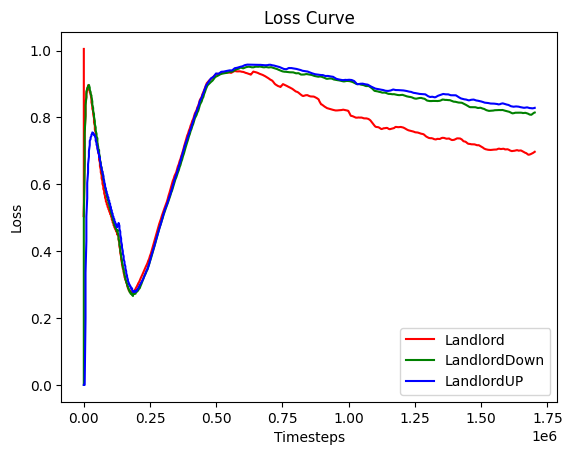

In [294]:
# 绘制的WP的loss图

# 1. loss图2张，每张包含Landlord，LandlordDown，LandlordUP
# x轴Timesteps, y轴Loss
# Landlord 红色
# LandlordDown 绿色
# LandlordUP 蓝色

# 从./douzero_checkpoints/douzero/logs.csv读取数据
# logs.csv中的数据有多列，其中frames代表timesteps, loss_landlord, loss_landlord_up, loss_landlord_down为对应的损失
# 将图片按照如下格式保存./image/loss/loss_{frames}_landlord_down_up.png
import pandas as pd
import matplotlib.pyplot as plt
import os

# 读取CSV文件中的数据
logs = pd.read_csv(f'.\log_for_image\loss\logs_wp_processed.csv')

# 按照timesteps（frames）排序
logs = logs.sort_values(by=['frames'])

# 对每个损失值应用滑动窗口平均函数，使其平滑处理
window_size = 80
logs['smooth_loss_landlord'] = logs['loss_landlord'].rolling(window=window_size, min_periods=1).mean()
logs['smooth_loss_landlord_down'] = logs['loss_landlord_down'].rolling(window=window_size, min_periods=1).mean()
logs['smooth_loss_landlord_up'] = logs['loss_landlord_up'].rolling(window=window_size, min_periods=1).mean()

# 绘制Landlord、LandlordDown和LandlordUP的损失曲线
plt.plot(logs['frames'], logs['smooth_loss_landlord'], color='red', label='Landlord')
plt.plot(logs['frames'], logs['smooth_loss_landlord_down'], color='green', label='LandlordDown')
plt.plot(logs['frames'], logs['smooth_loss_landlord_up'], color='blue', label='LandlordUP')

# 设置标题和轴标签
plt.title('Loss Curve')
plt.xlabel('Timesteps')
plt.ylabel('Loss')

# 显示图例
plt.legend()

# 保存图片到本地路径./image/loss/
# 检查文件夹是否存在，不存在则创建
if not os.path.exists('./image/loss/'):
    os.makedirs('./image/loss/')
filename = './image/loss/wp_loss_{}_landlord_down_up.png'.format(int(logs['frames'].max()))
plt.savefig(filename)

# 显示图表
plt.show()

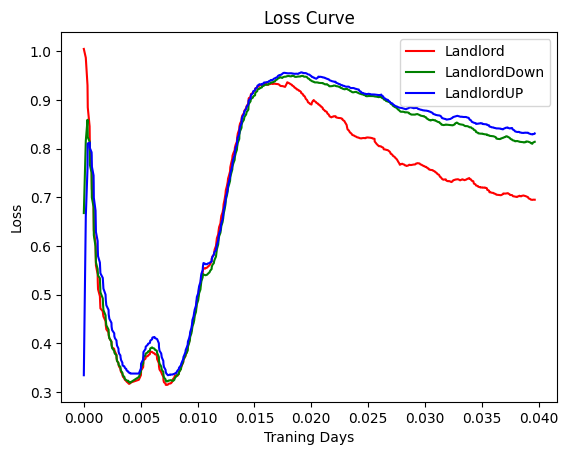

In [295]:
# WP的loss图
import pandas as pd
import matplotlib.pyplot as plt
import os

# 读取CSV文件中的数据
logs = pd.read_csv(f'.\log_for_image\loss\logs_wp_processed.csv')

# 将时间戳转换为datetime格式并按照日期排序
logs['_time'] = pd.to_datetime(logs['_time'], unit='s')

# 计算每个时间点距离最早时间点的天数，并创建一个新列
earliest_time = logs['_time'].min()
logs['days_since_earliest'] = (logs['_time'] - earliest_time).dt.total_seconds() / 86400.

# 按天聚合数据并计算每个组的平均损失值
logs_daily = logs.groupby('days_since_earliest').mean()

# 对每个损失应用滑动窗口平均函数，以平滑处理
window_size = 80
logs_daily['smooth_loss_landlord'] = logs_daily['loss_landlord'].rolling(window=window_size, min_periods=1).mean()
logs_daily['smooth_loss_landlord_down'] = logs_daily['loss_landlord_down'].rolling(window=window_size, min_periods=1).mean()
logs_daily['smooth_loss_landlord_up'] = logs_daily['loss_landlord_up'].rolling(window=window_size, min_periods=1).mean()

# 绘制Landlord、LandlordDown和LandlordUP的损失曲线
plt.plot(logs_daily.index, logs_daily['smooth_loss_landlord'], color='red', label='Landlord')
plt.plot(logs_daily.index, logs_daily['smooth_loss_landlord_down'], color='green', label='LandlordDown')
plt.plot(logs_daily.index, logs_daily['smooth_loss_landlord_up'], color='blue', label='LandlordUP')

# 设置标题和轴标签
plt.title('Loss Curve')
plt.xlabel('Traning Days')
plt.ylabel('Loss')

# 显示图例
plt.legend()

# 保存图片到本地路径./image/loss/
# 检查文件夹是否存在，不存在则创建
if not os.path.exists('./image/loss/'):
    os.makedirs('./image/loss/')
filename = './image/loss/wp_loss_day_{}_landlord_down_up.png'.format(int(logs['frames'].max()))
plt.savefig(filename)

# 显示图表
plt.show()


In [296]:
# 2. ADP和WP图，4张图(ADP有2张图，分别是横坐标为Timesteps和Traing Days。WP也有两张图，分别是分别是横坐标为Timesteps和Traing Days)，每张图是Landlord和Peasants
#
# Landlord 红色
# Peasants 蓝色

# ADP图1：横坐标为Timesteps，纵坐标为ADP，Landlord和Peasants
# ADP图2：横坐标为Traing Days，纵坐标为ADP，Landlord和Peasants
# WP图1：横坐标为Timesteps，纵坐标为WP，Landlord和Peasants
# WP图2：横坐标为Traing Days，纵坐标为WP，Landlord和Peasants

# 从./douzero/logs.csv读取数据
# logs.csv中的数据有多列，其中frames代表timesteps, loss_landlord, loss_landlord_up, loss_landlord_down为对应的损失
# 将图片按照如下格式保存./image/loss/loss_{frames}_landlord_down_up.png

In [297]:
# 3. Accuracy图，3张，Landlord，LandlordDown，LandlordUP


In [298]:
# 4. WP 对抗SL智能体，ADP对抗SL智能体，WP对抗DeltaDou智能体，ADP对抗DeltaDou智能体
